In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from steady_state import mask_steady_state
from earth_network_constants import random_couplings, var_names
from pycascades_solver import *
from detection_power import coupling_to_graph, detection_power

import tigramite
import tigramite.plotting
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.data_processing import DataFrame
from tigramite.toymodels import structural_causal_processes

In [4]:
def varx(var_n, b, t=np.inf):
    return var_n/(2*b)*(1 - np.exp(-2*b*t))

def covx(var_n, b, t1, t2):
    return var_n/(2*b)*(np.exp(-b*abs(t1 - t2)) - np.exp(-b*(t1 + t2)))

## Noise Level for Unperturbed Element

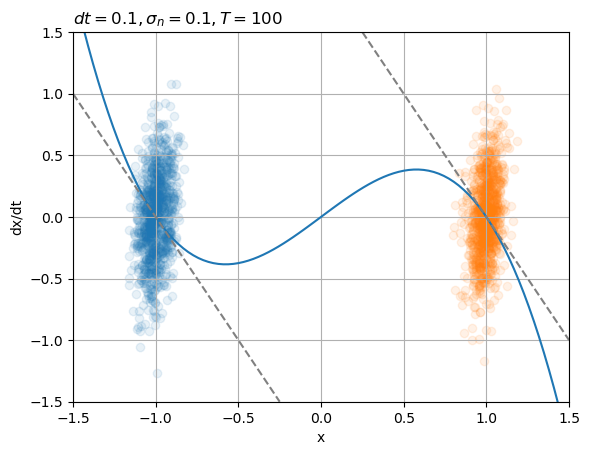

               left      right    analytical  simplification
--------  ---------  ---------  ------------  ---------------------
E[X]      -0.00126   -0.00455         0
V[X]       0.00357    0.00294         0.0025  0.0025000000000000005
E[dX/dt]   0.000738  -0.000596        0
V[dX/dt]   0.117      0.107           0.11    0.09990000000000002


In [242]:
noise = 0.1
n = 1000
T = 100
t = np.linspace(0, T, n)
dt = tspan[1] - tspan[0]

# plot analytical derivative
x  = np.linspace(-1.5, 1.5, 100)
dx = [tipping_equation(-1.0, 1.0, 0.0, np.zeros((2,2)))(np.array([xx, 0]), None)[0] for xx in x]
plt.plot(x, dx)

# plot approximations around mean state
[plt.axline((x, 0), (x+1, -2), ls="--", c="gray") for x in [-1, 1]]

# solve equation and reconstruct derivative
X  = solve(-1, 1, 0, np.zeros((2,2)), noise, y0=np.array([-1, 1]), tspan=t)
dXdt = np.diff(X, axis=0)/dt

# plot points in phase space
[plt.scatter(X[1:,i], dXdt[:,i], alpha=0.1) for i in range(2)]

plt.title(f"$dt={dt:.2g}, \sigma_n={noise:.2g}, T={T}$", x=0, horizontalalignment="left")
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.grid()
plt.xlabel("x")
plt.ylabel("dx/dt")
plt.show()

b=2
var_x_analytic  = noise**2*(1-np.exp(-2*b*T))/(2*b)
var_dx_analytic = noise**2*((b-b*np.exp(-2*b*T))/2*dt**2 + dt)

X = X - np.array([-1, 1])
print(tabulate([
    ["E[X]", *X.mean(axis=0), 0.0, ""],
    ["V[X]", *X.var(axis=0), var_x_analytic, noise**2/(2*b)],
    ["E[dX/dt]", *dXdt.mean(axis=0), 0.0, ""],
    ["V[dX/dt]", *dXdt.var(axis=0), var_dx_analytic/dt**2, noise**2/dt]],
    headers=["", "left", "right", "analytical", "simplification"], floatfmt=".3g", #tablefmt="latex"
))

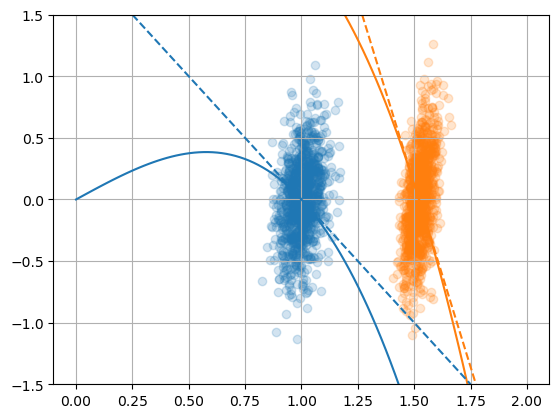

In [762]:
noise = 0.1
n = 1000
T = 100
t = np.linspace(0, T, n)
dt = tspan[1] - tspan[0]

Y = solve(-1, 1, 0, np.array([[0.0, 0.0], [1.0, 0.0]]), noise_level=noise, y0="tipped", tspan=t)

x = np.linspace(0, 2, 100)
plt.grid()
plt.ylim([-1.5, 1.5])

# analytical derivatives
plt.plot(x, -x**3 + x)
plt.plot(x, -x**3 + x + 2)

# slope in root of x0
plt.axline([1, 0], slope=-2, ls="--")

# slope in root of x1
x1 = sp.optimize.root(lambda x: -x**3 + x + 2, x0 = 1, tol=1e-6).x[0]
plt.axline([x1, 0], slope=-3*x1**2 + 1, ls="--", c="C1")

# simulated phase space points
[plt.scatter(Y[:,i], np.diff(Y[:,i], prepend=0)/0.1, alpha=0.2) for i in range(2)]

plt.show()

In [910]:
from sdeint import itoEuler, itoSRI2

n  = 5000
T  = 50
t  = np.linspace(0, T, n)
dt = t[1] - t[0]
b = 2

def f(y, t):
    return -b*y

def solve(noise_level, solver=itoEuler, N=1):
    return np.array([solver(f, lambda y, t: noise_level, 0, t) for n in range(N)])

noises = np.linspace(0, 5, 30)

In [912]:
ys = np.squeeze(np.array([solve(noise, N=100) for noise in noises]))

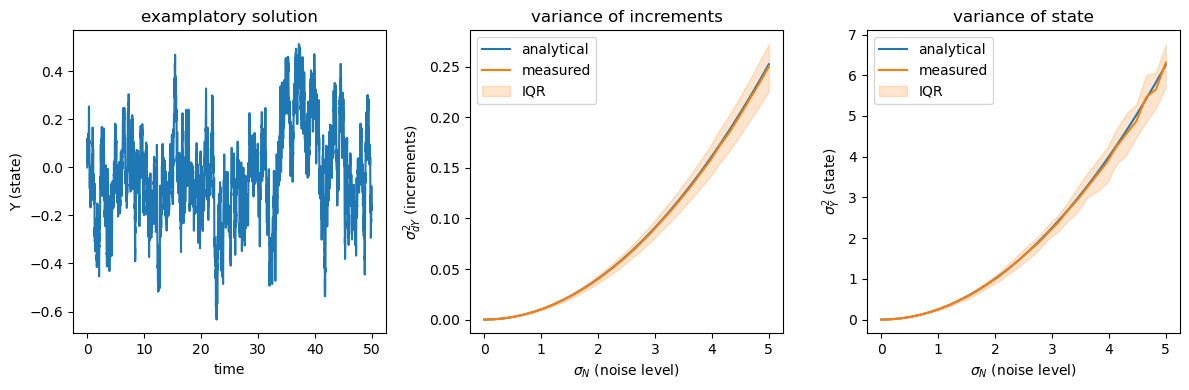

In [916]:
# shape y = (noise, runs, time)

# variance of values for each run
var_dy = np.diff(ys, axis=2).var(axis=1)
var_y  = ys.var(axis=2)

var_dy_analytic = noises**2*((1-np.exp(-2*b*T))/(2*b)*b**2*dt**2 + dt)
var_y_analytic  = noises**2*(1-np.exp(-2*b*T))/(2*b)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title(f"examplatory solution")
plt.plot(np.linspace(0, T, n), itoEuler(f, lambda y, t: 0.4, 0, t))
plt.xlabel("time")
plt.ylabel("Y (state)")

plt.subplot(132)
plt.title(f"variance of increments")
plt.plot(noises, var_dy_analytic, label="analytical")
plt.plot(noises, var_dy.mean(axis=1), label="measured", c="C1")
plt.fill_between(noises, np.quantile(var_dy, 0.25, axis=1), np.quantile(var_dy, 0.75, axis=1), color="C1", label="IQR", alpha=0.2)
plt.ylabel("$\sigma_{dY}^2$ (increments)")
plt.xlabel("$\sigma_N$ (noise level)")
plt.legend()

# mean and IQR over all time steps
plt.subplot(133)
plt.title(f"variance of state")
plt.plot(noises, var_y_analytic, label="analytical")
plt.plot(noises, var_y.mean(axis=1), label="measured")
plt.fill_between(noises, np.quantile(var_y, 0.25, axis=1), np.quantile(var_y, 0.75, axis=1), color="C1", label="IQR", alpha=0.2)
plt.ylabel("$\sigma_Y^2$ (state)")
plt.xlabel("$\sigma_N$ (noise level)")
plt.legend()

plt.tight_layout()
plt.show()

In [903]:
y = np.array([itoEuler(f, lambda y, t: 1, 0, np.linspace(0, 100, 10000)) for n in range(100)]).squeeze()

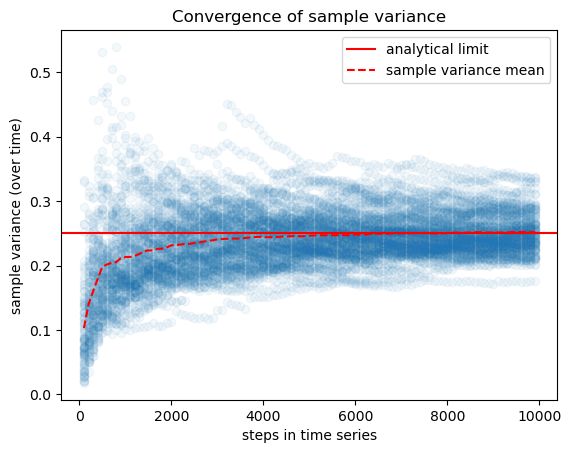

In [925]:
T = np.arange(100, 10000, 100)

plt.title("Convergence of sample variance")
[plt.scatter(T, [y[i,0:_].var() for _ in T], c="C0", alpha=0.05) for i in range(100)]
plt.axhline(1**2/(2*2), c="red", label="analytical limit")
plt.plot(T, np.mean([y[:,0:_].var(axis=1) for _ in T], axis=1), color="red", ls="--", label="sample variance mean")
plt.ylabel("sample variance (over time)")
plt.xlabel("steps in time series")
plt.legend()
plt.show()

## Noise Level for Coupled Elements

In [5]:
from pycascades_solver import *

In [16]:
b = 2
noise = 0.1
T = 100
n = 10000
t = np.linspace(0, T, n)
dt = t[1] - t[0]

ds = np.linspace(0, 5, 50)
Ys = np.array([solve(-1, 1, 0, np.array([[0.0, 0.0], [d, 0.0]]), noise_level=noise, y0=np.array([1, 1 + d**(1/3)]), tspan=t) for d in ds])

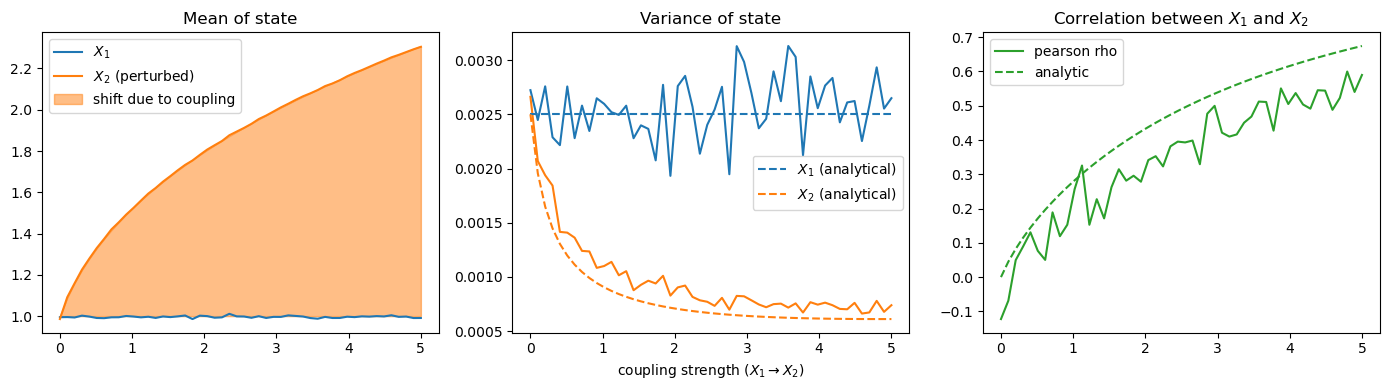

In [17]:
# zero of shifted equation + expectation of noise integral
mean_x_equation = np.array([sp.optimize.root(lambda x: -x**3 + x + d*(1+1), x0=1).x for d in ds]).ravel()
mean_x_analytic = mean_x_equation

# linearization at the zero of the shifted equation (negative sign due to definition of Ornstein-Uhlbeck equation)
b_shifted = -(-3*mean_x_analytic**2 + 1)

# analytic variance for one coupling
var_x_analytic = noise**2/(2*b_shifted) + ds**2/b_shifted**2*varx(noise**2, 2)

plt.figure(figsize=(14, 4))

# mean
plt.subplot(131)
plt.title("Mean of state")
plt.plot(ds, Ys.mean(axis=1), label=["$X_1$", "$X_2$ (perturbed)"])
plt.fill_between(ds, 1, mean_x_equation, color="C1", alpha=0.5, label="shift due to coupling")
plt.legend()

# variance
plt.subplot(132)
plt.title("Variance of state")
plt.plot(ds, Ys.var(axis=1))
plt.plot(ds, varx(noise**2, 2) + 0*ds, c="C0", ls="--", label=r"$X_1$ (analytical)")
plt.plot(ds, var_x_analytic, c="C1", ls="--", label=r"$X_2$ (analytical)")
plt.xlabel(r"coupling strength ($X_1 \rightarrow X_2$)")
plt.legend()


rho = np.array([sp.stats.pearsonr(y[:,0], y[:,1]).statistic for y in Ys])

# correlation coefficient
plt.subplot(133)
plt.title(r"Correlation between $X_1$ and $X_2$")
plt.plot(ds, rho, c="C2", label="pearson rho")
plt.plot(ds, noise**2*ds/(2*2*b_shifted)/varx(noise**2, 2)**0.5/var_x_analytic**0.5, c="C2", ls="--", label="analytic")
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
import networkx as nx

def is_acyclic(d):
    d = (d - np.diag(d)) != 0
    for n in range(d.shape[0]):
        d = d@d
        if np.any(np.diag(d)):
            return False
    return True
    
def find_stable_states(d):
    # adjacency matrix
    d = (d - np.diag(d)) != 0
    
    return sp.optimize.fsolve(lambda x: -x**3 + x + d@x, x0=np.repeat(1.5, d.shape[0]))